# Subradar Point over Apophis

Agustin Vallejo

In [1]:
import pandas as pd
import numpy as np

"MATPLOTLIB"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm

mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [2]:
ephemeris = pd.read_csv("../ephemeris2.csv")
radio = pd.read_csv("../AllRadiotelescopes.csv")

# Astropy

In [3]:
"ASTROPY"
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.modeling.rotations import RotationSequence3D
from astropy.constants import c
import astropy.units as u

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

## Main Functions

In [5]:
# Obtains the Astropy Position Vector of given earth coordinates
pos = lambda x,h: EarthLocation(lon=x['Longitude']*u.deg,lat=x['Latitude']*u.deg,height=h*u.earthRad)

# Transforms an Astropy object into a simple 3-tuple vector
vec = lambda a:  (a.x.value,
                  a.y.value,
                  a.z.value)

# Returns the magnitude of a vector
dist = lambda v: np.linalg.norm(v)

# Returns the angle between two vectors in degrees
angle = lambda v1,v2: np.rad2deg( np.arccos( np.dot(v1,v2) / (dist(v1) * dist(v2)) ) )

def zenith_ecuat(obs, obs_time):
    """
    Obtains the coordinates of the observer's zenith at obs_time (jd)
    """
    zenith = SkyCoord(az=0*u.deg, alt=90*u.deg, distance=1*u.earthRad,
                      location=pos(obs,0), obstime=Time(obs_time, format='jd'), frame='altaz')
    return zenith.gcrs

def get_apo_to_earth(apo,obs,only_visible=True):
    """
    This function outputs the coordinates of an observatory as seen by Apophis.
    only_visible: If True, only returns points unobstructed by earth, invisible ones are None.
    If False, return all points.
    """
    # Apophis' coordinates
    apo_sky = SkyCoord(ra=apo['RA']*u.deg,dec=apo['DEC']*u.deg,
                       distance=apo['delta (Rt)']*u.earthRad)
    obs_time = Time(apo['datetime_jd'], format='jd')
    if not (obs is None):
        obs_zenith = zenith_ecuat(obs, obs_time)
        # Dot product to determine if there's visibility:
        dot = np.dot(vec(apo_sky.cartesian),vec(obs_zenith.cartesian))
        if only_visible and dot < 0:
            return None
        apo_to_obs = SkyCoord(obs_zenith.cartesian - apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    else:
        apo_to_obs = SkyCoord(-apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    return apo_to_obs

def new_coordinates_matrix():
    """
    Generates a rotation matrix with respect to Apophís moment of intertia
    https://ned.ipac.caltech.edu/coordinate_calculator?in_csys=Ecliptic&in_equinox=J2000.0&obs_epoch=2000.0&lon=250&lat=-75&pa=0.0&out_csys=Equatorial&out_equinox=J2000.0
    https://www.aanda.org/articles/aa/pdf/2018/09/aa32914-18.pdf
    """
    # NEW Z AXIS
    new_z = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad)
    new_z = vec(new_z.cartesian)
    new_z /= np.linalg.norm(new_z)

    # NEW X AXIS
    new_x = SkyCoord(ra=0*u.deg,dec=0*u.deg,
                       distance=1*u.earthRad)
    new_x = vec(new_x.cartesian)
    new_x = np.cross(new_z,new_x)
    new_x /= np.linalg.norm(new_x)

    # NEW Y AXIS
    new_y = np.cross(new_z,new_x)
    new_y /= np.linalg.norm(new_y)

    ROT = np.matrix([new_x,new_y,new_z])
    return ROT

def to_asteroid_coordinates(v_gcrs,t):
    """
    Gets a vector in gcrs representation and generates the
    Asteroid local coordinates for a given time t.

    Asteroid coordinates are based on the axis of rotation.
    """
    v_subradar = to_subradar_coordinates(v_gcrs)
    v_subradar_rotated = rotate_asteroid(v_subradar,t)
    return v_subradar_rotated

def to_subradar_coordinates(v_gcrs):
    """
    Gets a vector in gcrs representation and generates the
    Asteroid local coordinates for a time 0.
    """
    ROT = new_coordinates_matrix()
    v_subradar = np.matmul(ROT,vec(v_gcrs.cartesian))
    v_subradar = np.array(v_subradar).flatten()
    return SkyCoord(*v_subradar,representation_type='cartesian').gcrs

def rotate_asteroid(v_subradar,t):
    ROT = rotation_matrix(t)
    v_subradar_rotated = np.matmul(ROT,vec(v_subradar.cartesian))
    v_subradar_rotated = np.array(v_subradar_rotated).flatten()
    return SkyCoord(*v_subradar_rotated,representation_type='cartesian').gcrs

def rotation_matrix(t):
    omega = 2*np.pi/(27.38/24)
    theta = omega*t
    ROT = np.matrix([[np.cos(theta),np.sin(theta),0],
                     [-np.sin(theta),np.cos(theta),0],
                     [0,0,1]])
    return ROT

def get_subradar_points(ephemeris,obs):
    """
    This function iterates over the ephemeris to generate subradar points 
    for a specific observatory
    """
    output = {"date":[],
              "date_jd": [],
              "ra":[],
              "dec":[],
              "lon":[],
              "lat":[],
              "latR":[],
              "lonR":[],
              "dist":[]}

    date0 = ephemeris['datetime_jd'][ephemeris['delta (Rt)'].idxmin()]
    for r,row in ephemeris.iterrows():
        point = get_apo_to_earth(row,obs)
        if point:
            point_sub = to_subradar_coordinates(point)
            output['date'] += [row['datetime_str']]
            output['date_jd'] += [row['datetime_jd']]

            # ECUATORIAL COORDINATES OF OBSERVATORY FROM APOPHIS
            output['ra']   += [point.ra.value]
            output['dec']  += [point.dec.value]

            # LOCAL COORDINATES OF OBS FROM APOPHIS
            output['lat']  += [point_sub.dec.value]
            if point_sub.ra.value < 180:
                output['lon'] += [point_sub.ra.value]
            else:
                output['lon'] += [point_sub.ra.value - 360]

            # LOCAL COORDINATES OF OBS FROM APOPHIS APPLYING ROTATION
            t = row['datetime_jd'] - date0
            point_sub_rotated = rotate_asteroid(point_sub,t)
            output['latR']  += [point_sub_rotated.dec.value]
            if point_sub_rotated.ra.value < 180:
                output['lonR'] += [point_sub_rotated.ra.value]
            else:
                output['lonR'] += [point_sub_rotated.ra.value - 360]

            output['dist'] += [row['delta (Rt)']]
    return output

In [6]:
# TEST CELL OF COORDINATE TRANSFORMATION
point = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad) # THIS IN PARTICULAR IS THE POINTING VECTOR OF THE ASTEROID MOMENT OF INERTIA
MIN = ephemeris['delta (Rt)'].argmin()
to_subradar_coordinates(point) # Should have a latitude close to 90°

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (189.57750355, 89.99422692)>

## Subradar Points

In [7]:
radio.Name

0              Canberra DSS-43
1                       Parkes
2                Madrid DSS-63
3                       Lovell
4                   Effelsberg
5                    AVN-Ghana
6                    Goldstone
7                   Green Bank
8             Very Large Array
9                      Arecibo
10                        FAST
11                       EDSCC
12    Usuda Deep Space Center 
Name: Name, dtype: object

In [8]:
obs = radio.iloc[3]
obs = {'Name':"Earth's Center"}
subradar_points = pd.DataFrame(get_subradar_points(ephemeris,None))
# subradar_points.to_csv("../Data/subradar_points.csv")

In [9]:
subradar_points

,date,date_jd,ra,dec,lon,lat,latR,lonR,dist
0,2029-Apr-13 13:30,2462240.063,20.17701,23.94602,-114.590194,-25.094418,-25.097150,-6.355273,30.165656
1,2029-Apr-13 13:35,2462240.066,20.05465,23.87547,-114.453582,-25.047769,-25.050487,-7.165424,29.882975
2,2029-Apr-13 13:40,2462240.069,19.93009,23.80346,-114.314466,-25.000088,-25.002792,-7.973069,29.600302
3,2029-Apr-13 13:45,2462240.073,19.80327,23.72997,-114.172780,-24.951365,-24.954050,-9.093736,29.317638
4,2029-Apr-13 13:50,2462240.076,19.67413,23.65493,-114.028450,-24.901544,-24.904213,-9.896165,29.034985
...,...,...,...,...,...,...,...,...,...
195,2029-Apr-14 05:45,2462240.740,201.52165,-24.70663,63.922720,25.594497,25.595690,-41.478897,29.310575
196,2029-Apr-14 05:50,2462240.743,201.39295,-24.63440,64.065894,25.547406,25.548569,-42.282454,29.593250
197,2029-Apr-14 05:55,2462240.747,201.26684,-24.56342,64.206241,25.501060,25.502181,-43.404416,29.875936
198,2029-Apr-14 06:00,2462240.750,201.14323,-24.49367,64.343855,25.455454,25.456545,-44.213531,30.158631


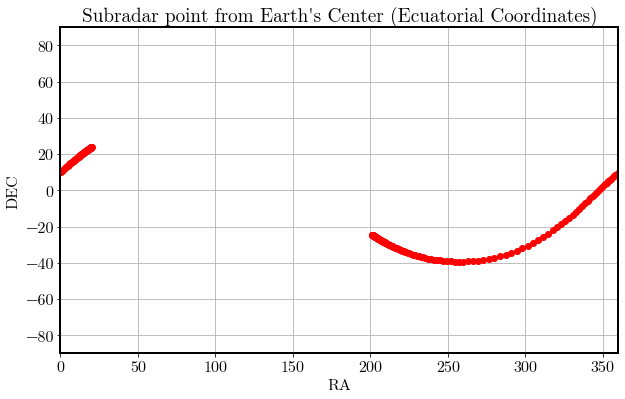

In [10]:
plt.figure(figsize=(10,6))
# plt.plot(180+ephemeris['RA'],-1*ephemeris['DEC'],'bo',label="Ecuatorial Coordinates of Earth from Apophis")
plt.plot(subradar_points.ra,subradar_points.dec,'ro',label="Ecuatorial Coordinates of Observatory from Apophis")
plt.xlim([0,360])
plt.ylim([-90,90])
# plt.legend()
plt.title("Subradar point from "+obs['Name'] + " (Ecuatorial Coordinates)")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.grid()

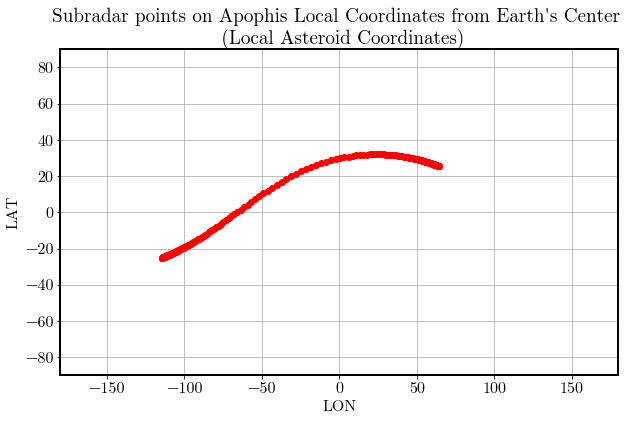

In [11]:
plt.figure(figsize=(10,6))
plt.plot(subradar_points.lon,subradar_points.lat,'ro')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.title("Subradar points on Apophis Local Coordinates from "+obs['Name']+" \n (Local Asteroid Coordinates)")
plt.xlabel("LON")
plt.ylabel("LAT")
plt.grid()

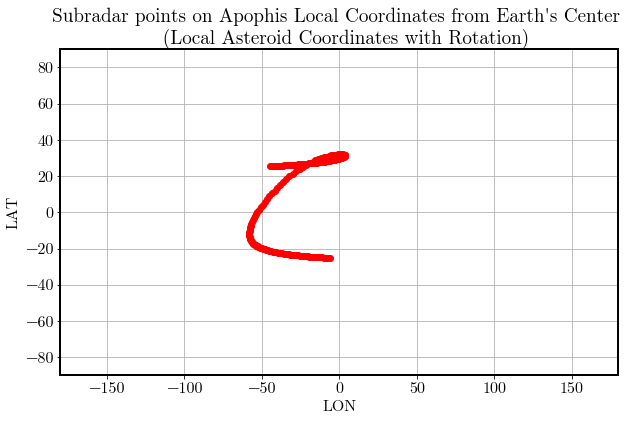

In [12]:
plt.figure(figsize=(10,6))
plt.plot(subradar_points.lonR,subradar_points.latR,'ro')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.title("Subradar points on Apophis Local Coordinates from "+obs['Name']+" \n  (Local Asteroid Coordinates with Rotation)")
plt.xlabel("LON")
plt.ylabel("LAT")
plt.grid()

In [13]:
min(subradar_points.dist)

5.960267316

## Surface Coverage

In [14]:
# Given longitude and latitude angles in degrees, return cartesian representation
spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

N_lons = 72
N_lats = 36
lons   = np.linspace(-180,180,N_lons)
lats   = np.linspace(-90,90,N_lats)

lon_grid, lat_grid = np.meshgrid(lons, lats)

def coverage(point):
    """
    Returns the meshgrid of all the radar coverage
    """
    out = np.zeros((N_lats,N_lons))
    dot = np.tensordot(spherical(point.lonR, point.latR),
                    spherical(lon_grid, lat_grid), axes=1)
    out[dot > 0] = 1
    return out

def full_coverage(subradar_points):
    out = np.zeros((N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        out += coverage(point)
    out /= np.max(out)
    return out

def full_coverage_SNR(subradar_points):
    out = np.zeros((len(ephemeris),N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        # out[r] = -coverage(point)*10*np.log10((5.960267316/point.dist)**4)
        out[r] = coverage(point)*(5.960267316/point.dist)**4
    out = np.max(out,axis=0)
    return out

In [15]:
full_cov_norm = full_coverage_SNR(subradar_points)

In [16]:
# full_cov_norm = full_cov.max(axis=0) #/ len(ephemeris)

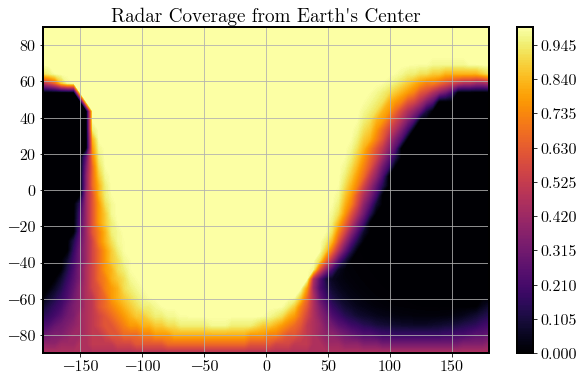

In [17]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111) #, projection = 'mollweide')
ax.set_title("Radar Coverage from "+obs['Name'])
axx = ax.contourf(lons, lats, full_cov_norm, cmap="inferno", levels=len(subradar_points))
ax.grid()
fig.colorbar(axx,ax=ax)
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [18]:
total_time = (ephemeris['datetime_jd'].iloc[-1]-ephemeris['datetime_jd'].iloc[0])*u.day.to(u.h)
total_time

full_cov_h = full_cov_norm*total_time

'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


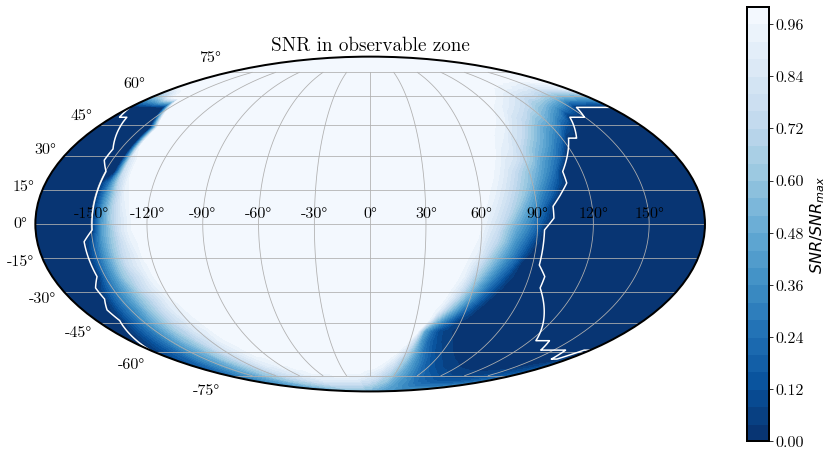

In [19]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("SNR in observable zone")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov_norm, cmap="Blues_r", levels=30)
axx1 = ax.contour(np.deg2rad(lons), np.deg2rad(lats), full_cov_norm,linestyle='dashed',levels=0, colors='white')
ax.grid()
# fig.colorbar(axx1,ax=ax)#, label="Visibility time [h]")
fig.colorbar(axx,ax=ax, label=r"$SNR/SNR_{max}$")

name = "../Figures/fig11_snr"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

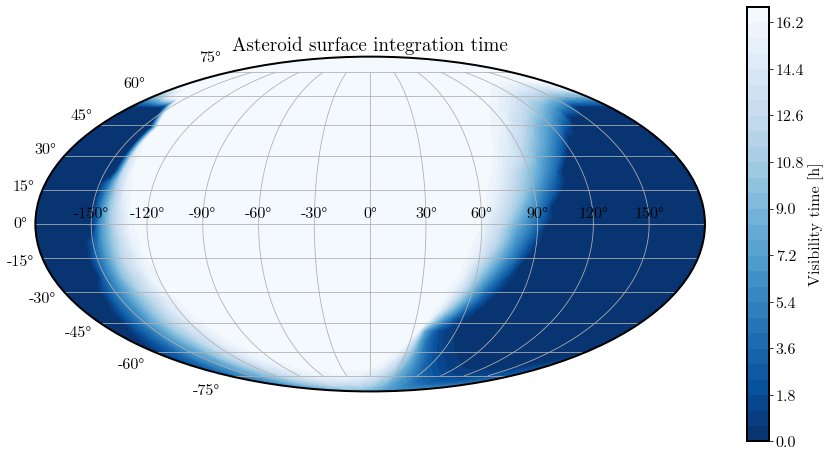

In [20]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov_h, cmap="Blues_r", levels=30)
ax.grid()
fig.colorbar(axx,ax=ax, label="Visibility time [h]")

In [21]:
MIN

99

In [22]:
threshold = 1/60 # h
covered = lambda x: 1 if x>threshold else x/threshold

integrable = np.vectorize(covered)(full_cov_h)

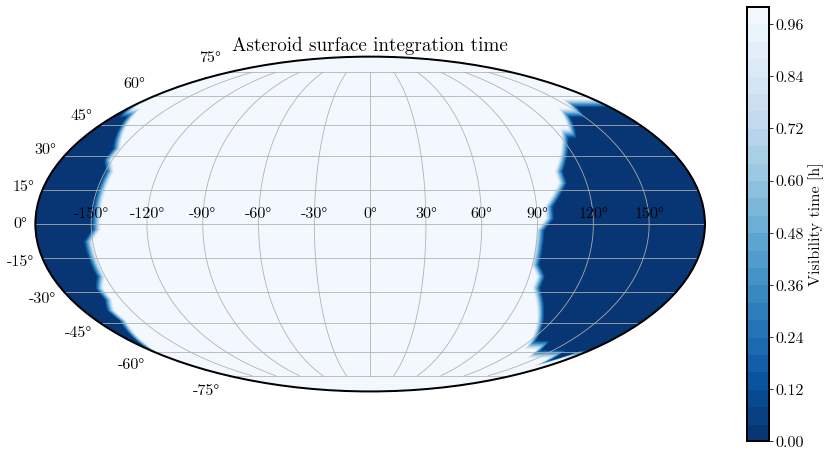

In [23]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), integrable, cmap="Blues_r", levels=30)
# ax.colorbar()
ax.grid()
fig.colorbar(axx,ax=ax, label="Visibility time [h]")
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [24]:
len(subradar_points)

200

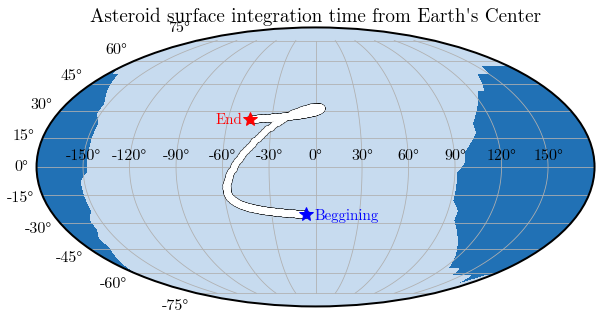

In [25]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time from "+obs['Name'])
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), integrable, cmap="Blues_r", levels=1)
ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)

last = len(subradar_points) - 1
ax.plot(np.deg2rad(subradar_points.lonR[0]),np.deg2rad(subradar_points.latR[0]),'b*',ms=15)
ax.plot(np.deg2rad(subradar_points.lonR[last]),np.deg2rad(subradar_points.latR[last]),'r*',ms=15)
ax.text(np.deg2rad(subradar_points.lonR[0])+0.1,np.deg2rad(subradar_points.latR[0])-0.05,"Beggining",color="blue", size=15)
ax.text(np.deg2rad(subradar_points.lonR[last])-0.4,np.deg2rad(subradar_points.latR[last])-0.05,"End",color="red",size=15)
# ax.colorbar()
ax.grid()
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [26]:
# subradar_points.to_csv("subradar_points.csv")

## Surface Coverage using All

In [27]:
ephemeris

,Unnamed: 0,Unnamed: 0.1,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,...,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat,delta (Rt),hours,Longitude,Latitude
0,0,0,99942 Apophis (2004 MN4),2029-Apr-13 13:30,2462240.063,19.7,0.25,NaN,NaN,200.17701,...,0.000005,233.7582,NaN,14.8796,205.5740,-7.1630,30.165656,0.000,155.471719,-23.94602
1,1,1,99942 Apophis (2004 MN4),2029-Apr-13 13:35,2462240.066,19.7,0.25,NaN,NaN,200.05465,...,0.000005,233.7754,NaN,14.8210,205.5095,-7.1515,29.882975,0.072,154.266402,-23.87547
2,2,2,99942 Apophis (2004 MN4),2029-Apr-13 13:40,2462240.069,19.7,0.25,NaN,NaN,199.93009,...,0.000005,233.7930,NaN,14.7623,205.4437,-7.1399,29.600302,0.144,153.058886,-23.80346
3,3,3,99942 Apophis (2004 MN4),2029-Apr-13 13:45,2462240.073,19.7,0.25,NaN,NaN,199.80327,...,0.000005,233.8109,NaN,14.7036,205.3767,-7.1280,29.317638,0.240,151.488123,-23.72997
4,4,4,99942 Apophis (2004 MN4),2029-Apr-13 13:50,2462240.076,19.7,0.25,NaN,NaN,199.67413,...,0.000005,233.8292,NaN,14.6449,205.3083,-7.1158,29.034985,0.312,150.276026,-23.65493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,99942 Apophis (2004 MN4),2029-Apr-14 05:45,2462240.740,19.7,0.25,NaN,NaN,21.52165,...,0.000005,288.6412,NaN,164.6205,136.9617,69.8595,29.310575,16.248,-267.570908,24.70663
196,196,196,99942 Apophis (2004 MN4),2029-Apr-14 05:50,2462240.743,19.7,0.25,NaN,NaN,21.39295,...,0.000005,288.6594,NaN,164.6866,137.3814,70.3041,29.593250,16.320,-268.782565,24.63440
197,197,197,99942 Apophis (2004 MN4),2029-Apr-14 05:55,2462240.747,19.7,0.25,NaN,NaN,21.26684,...,0.000005,288.6772,NaN,164.7506,137.8186,70.7427,29.875936,16.416,-270.352617,24.56342
198,198,198,99942 Apophis (2004 MN4),2029-Apr-14 06:00,2462240.750,19.7,0.25,NaN,NaN,21.14323,...,0.000005,288.6946,NaN,164.8124,138.2739,71.1754,30.158631,16.488,-271.559184,24.49367


In [28]:
radio.Code

plan = ['PRK','AVN','GBT','FAS']

plan = [radio[radio.Code == a].iloc[0] for a in plan]

In [29]:
all_integrable = np.zeros((N_lats,N_lons))

for obs in plan:
    subradar_points = pd.DataFrame(get_subradar_points(ephemeris,obs))
    full_cov = full_coverage(subradar_points)
    # full_cov_h = full_cov_norm*total_time
    # integrable = np.vectorize(covered)(full_cov_h)
    all_integrable += full_cov

In [37]:
subradar_points.latR[MIN]

26.38081315198271

'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


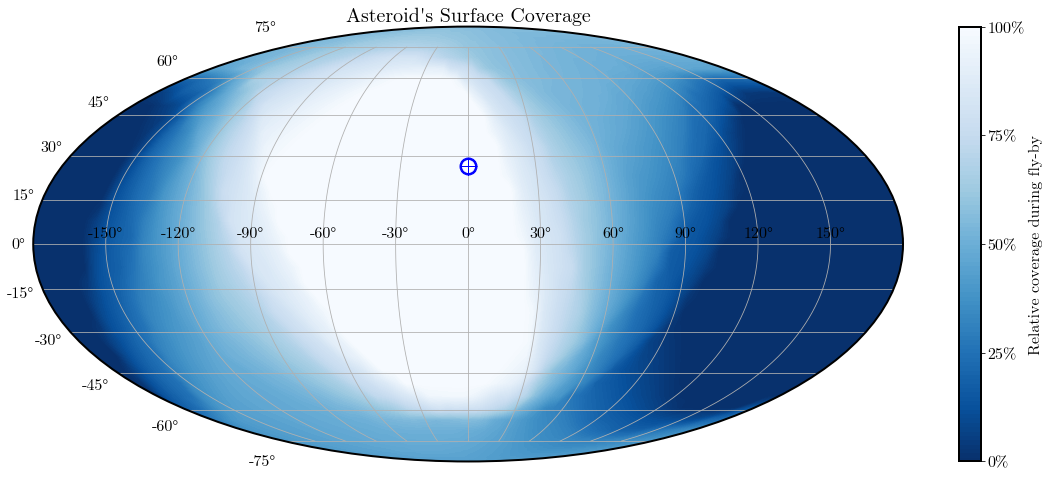

In [54]:
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid's Surface Coverage",size=20)
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), all_integrable/4, cmap="Blues_r", levels=100)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]*0),np.deg2rad(subradar_points.latR[MIN]),'bo',ms=17)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]*0),np.deg2rad(subradar_points.latR[MIN]),'wo',ms=12)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]*0),np.deg2rad(subradar_points.latR[MIN]),'b_',ms=17)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]*0),np.deg2rad(subradar_points.latR[MIN]),'b|',ms=17)
ax.grid()

cbar = fig.colorbar(axx, label="Relative coverage during fly-by")
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

name = "../Figures/fig10_coverage"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

1.0 0.8549382716049383
0.7515432098765432 0.7515432098765432
0.49382716049382713 0.49382716049382713
0.23765432098765432 0.23765432098765432
0.1385030864197531 0.0
2592
2216


(array([466., 120., 102., 169., 455., 458., 158., 104., 115., 445.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

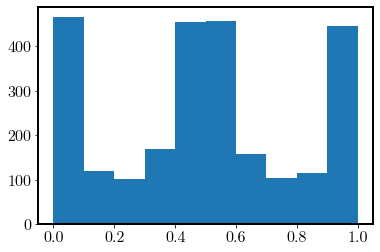

In [31]:
counts = all_integrable.flatten()
# plt.plot(np.sort(counts))
for k in [0,.25,.5,.75,1]:
    print(len(counts[counts>=4*k])/len(counts),end=' ')
    print(len(counts[counts>4*k])/len(counts))
print(len(counts))
print(np.count_nonzero(counts))
plt.hist(counts/4)